# Cross validation 

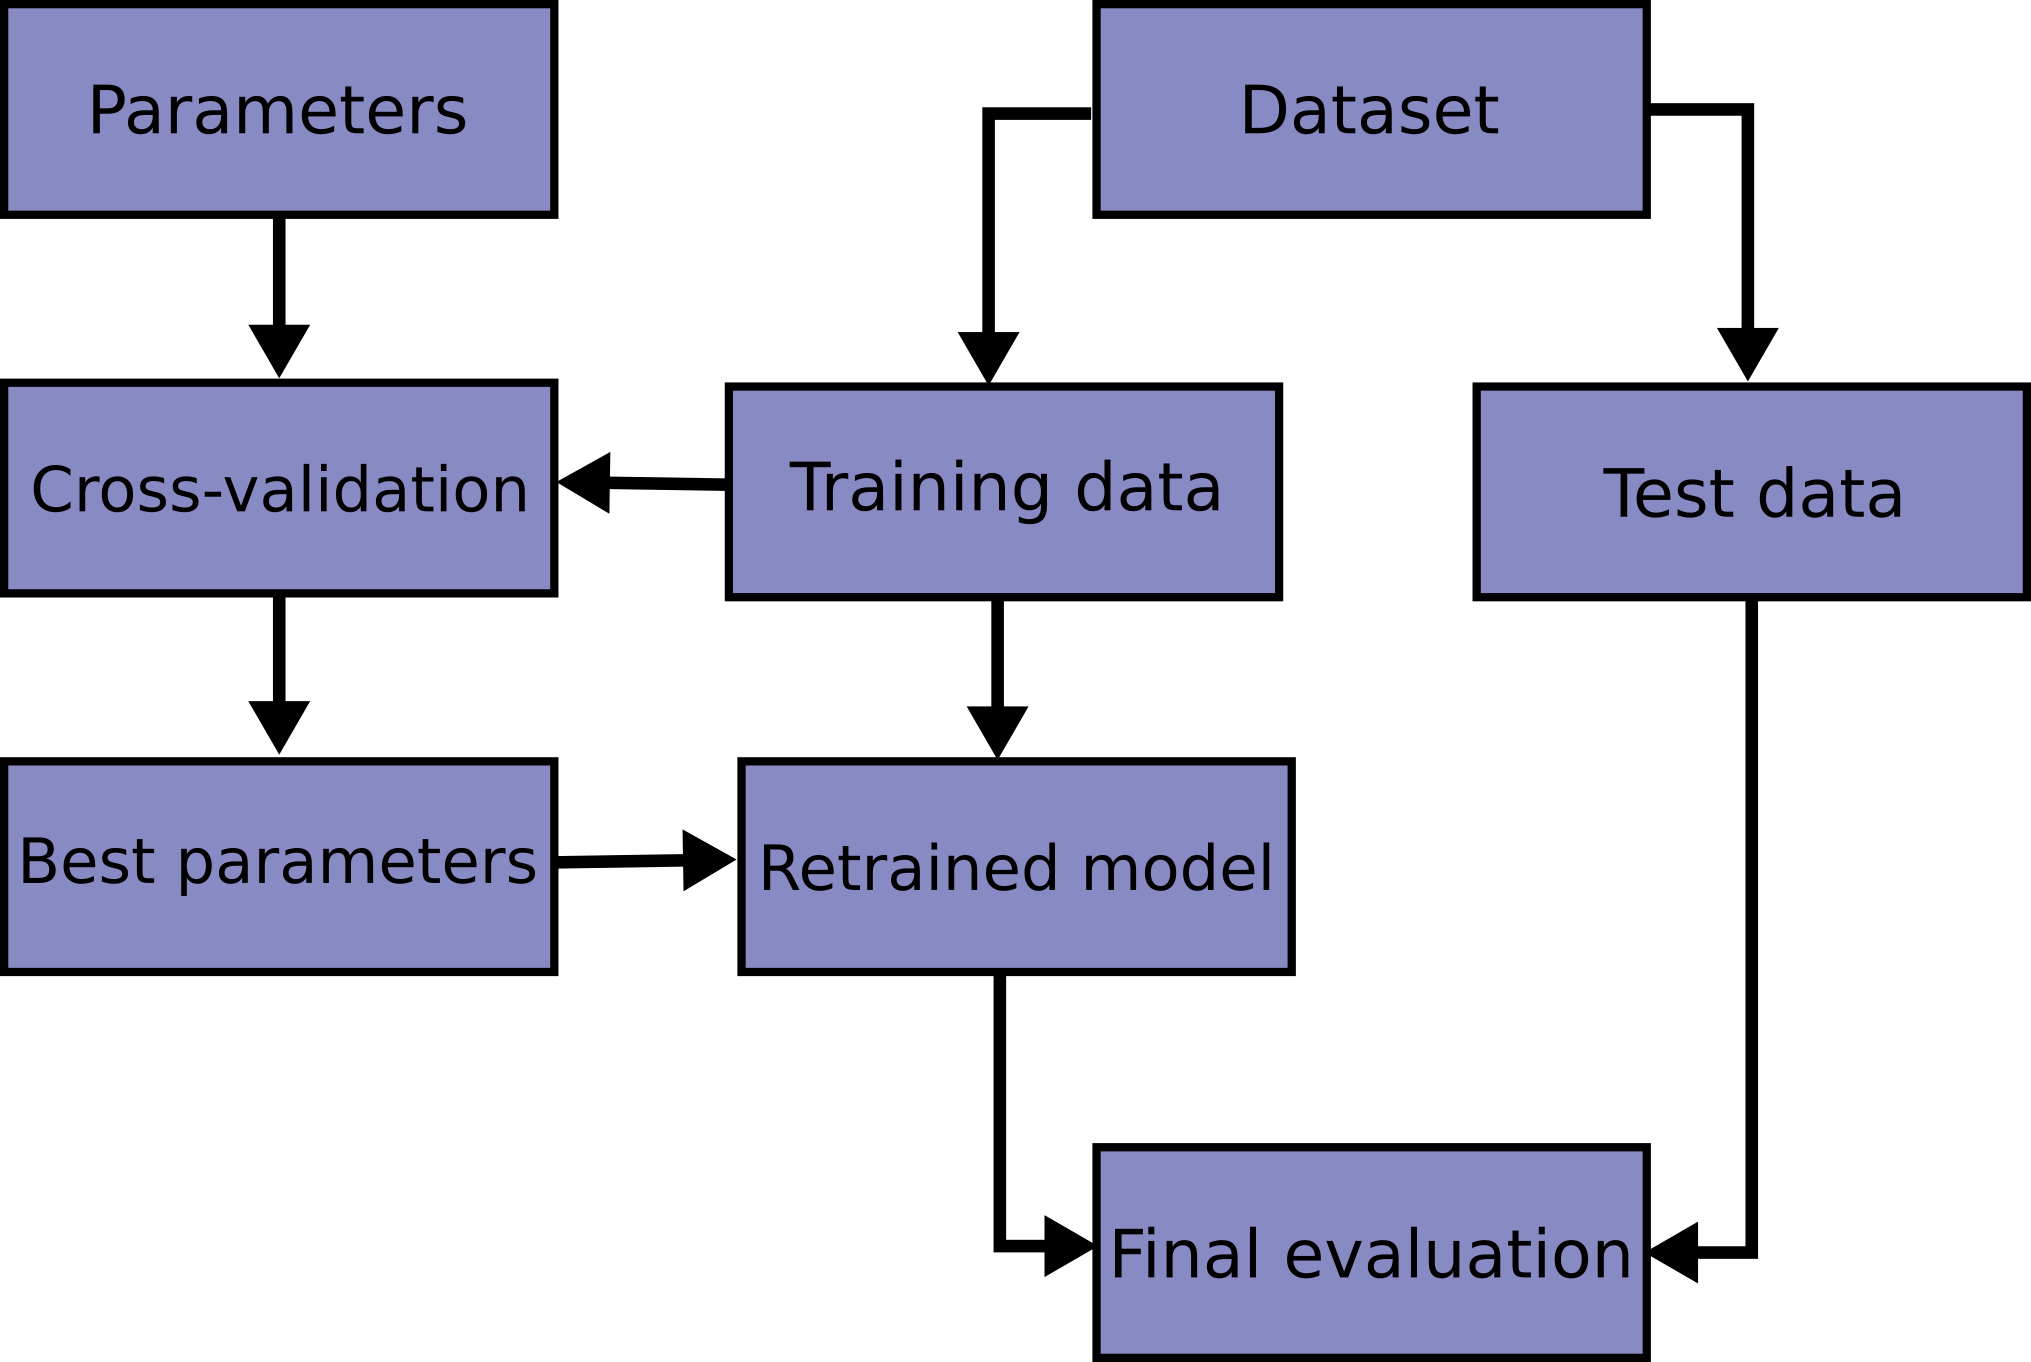

In [58]:

from PIL import Image
from IPython.display import display

img = Image.open('../images/grid_search_workflow.png')
display(img)


Holdout Validation:
- Split the dataset into two parts: a training set and a validation set.
- The model is trained on the training set and evaluated on the validation set.
- It is a simple approach, but the performance estimate can be sensitive to the random split.

K-Fold Cross-Validation:
- Divide the dataset into K equally sized folds (or subsets).
- Train the model K times, each time using K-1 folds for training and the remaining fold for validation.
- Calculate the average performance across all K folds.

Stratified K-Fold Cross-Validation:
- Similar to K-Fold, but ensures that each fold maintains the same class distribution as the original dataset.
- Particularly useful when dealing with imbalanced datasets.

Leave-One-Out Cross-Validation (LOOCV):
- Set K equal to the number of samples in the dataset.
- For each iteration, use one sample for testing and the remaining samples for training.
- Provides a high-variance estimate but can be computationally expensive for large datasets.

Leave-P-Out Cross-Validation:
- Similar to LOOCV but leaves P samples out for testing in each iteration.
- Reduces the computational burden compared to LOOCV.
  
Shuffle-Split Cross-Validation:
- Randomly shuffle the dataset and split it into training and validation sets multiple times.
- Provides a compromise between the low variability of K-Fold and the computational efficiency of Holdout.

Time Series Cross-Validation:
- Suitable for time series data where the order of observations matters.
- Divides the dataset into consecutive folds, training the model on past data and validating on future data.

Group K-Fold Cross-Validation:
- Similar to K-Fold but ensures that samples from the same group (e.g., subjects in a study) are either in the training or validation set.
- Useful when there is potential data leakage across folds.


# Hyperparameter tuning 

Grid Search:
- Description: Grid search exhaustively evaluates all possible combinations of hyperparameter values from predefined grids.
- Pros: Comprehensive exploration of the hyperparameter space.
- Cons: Computationally expensive, especially when the hyperparameter space is large.
python

Random Search:
- Description: Random search samples hyperparameter values randomly from predefined distributions or ranges.
- Pros: More computationally efficient than grid search, especially for large hyperparameter spaces.
- Cons: May not explore the entire space, relies on randomness.

Bayesian Optimization:
- Description: Bayesian optimization models the surrogate function representing the performance and uses it to guide the search towards promising regions.
- Pros: Efficient for expensive-to-evaluate functions, adapts to the shape of the search space.
- Cons: Requires an acquisition function and a probabilistic model.

Genetic Algorithms:
- Description: Genetic algorithms use principles of natural selection to evolve a population of potential solutions.
- Pros: Suitable for discrete and categorical hyperparameters, robust against local optima.
- Cons: Computationally expensive, requires defining genetic operators.

HalvingGridSearchCV and HalvingRandomSearchCV:
- Description: Dynamic resource allocation algorithms that start with a small subset of configurations and allocate more resources to promising ones.
- Pros: Efficient use of computational resources, adapts to the performance of configurations.
- Cons: Configuration elimination might lead to suboptimal solutions.

# Setup steps

## Basic: 
- an estimator (regressor or classifier such as sklearn.svm.SVC());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

## Our version: 
- Load data
- Split by group and keep the holdout test set
- Determine your cross validation strategy 
- Build a pipeline with an estimator of your selection
- Setup your parameter grid which could potentially include all that's tunable in each of the transformation step
- Determine your search strategy
- Fit your training data using the search strategy during cross validation which will result in the best set of hyperparameters
- Predict your heldout test set using the tuned hyperparameters + fitted parameters
- Evaluate your performance by looking at the performance metrics

In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.


In [43]:
import logging 
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import sklearn.model_selection

import algo_ecg.data
import algo_ecg.preprocessing
from algo_ecg.feature_transformer import \
    AllFeatureCustomTransformer, \
    RemoveCorrelatedFeatures

from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, \
    train_test_split, GroupShuffleSplit, cross_val_score, GroupKFold, \
    StratifiedGroupKFold

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from scipy.signal import find_peaks
import pandas as pd

from xgboost import XGBClassifier
from itertools import product

from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, \
    classification_report, roc_curve, confusion_matrix, auc, accuracy_score, precision_score

from joblib import parallel_backend, Parallel, delayed
from timeout_decorator import timeout

from concurrent.futures import ThreadPoolExecutor, TimeoutError
import pickle 


# Read in the data and preprocess it
The preprocessing step could potentially be added as part of the pipeline. 


In [3]:
#X_in, y = algo_ecg.data.import_physionet_data('../data')
X_in, y, pids = algo_ecg.data.import_physionet_data('/Users/jessie/data/PhysioNet_CinC',\
                                                    num_files_to_read=1000)
X, pids = algo_ecg.preprocessing.preprocess_pid(X_in, pids)

In [4]:
slice_length = len(X[0])
X = np.concatenate(X).reshape(-1, slice_length, 1)

In [5]:
# Hold out a test set using 
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7)
split = splitter.split(X, groups=pids)
train_inds, test_inds = next(split)

In [6]:
X_train = X[train_inds]
X_test = X[test_inds]

y_train = y[train_inds]
y_test = y[test_inds]

pids_train = pids[train_inds]
pids_test = pids[test_inds]

In [7]:
print(pids_train[:10])
print(pids_test[:10])

['A00001' 'A00002' 'A00003' 'A00003' 'A00005' 'A00005' 'A00006' 'A00007'
 'A00009' 'A00010']
['A00004' 'A00019' 'A00036' 'A00037' 'A00037' 'A00048' 'A00081' 'A00081'
 'A00084' 'A00085']


# Pick your cross validation strategy

In [8]:
splitter = StratifiedGroupKFold(n_splits=3)

'''
for i, (train_index, test_index) in enumerate(splitter.split(X, y, pids)):
    print(f"Fold {i}:")
    print(f"  Train: index={len(train_index)}, group={len(set(pids[train_index]))}")
    print(f"  Test:  index={len(test_index)}, group={len(set(pids[test_index]))}")
''' 

'\nfor i, (train_index, test_index) in enumerate(splitter.split(X, y, pids)):\n    print(f"Fold {i}:")\n    print(f"  Train: index={len(train_index)}, group={len(set(pids[train_index]))}")\n    print(f"  Test:  index={len(test_index)}, group={len(set(pids[test_index]))}")\n'

In [9]:
X_train = pd.DataFrame.from_records(X_train)
X_test = pd.DataFrame.from_records(X_test)

In [56]:
X_train.shape

(544, 9000)

# Build your pipeline with an estimator of choice

In [15]:

pipe = Pipeline(steps=[
    ('features_all',AllFeatureCustomTransformer(axis = 1)), 
    ('feature_selection_corr', RemoveCorrelatedFeatures(threshold=0.9)), 
    ('feature_selection', SelectFromModel(LinearSVC(dual="auto", 
                                                    penalty="l1", 
                                                    C = 0.01, 
                                                    class_weight = "balanced", 
                                                    max_iter=1000))), 
    ('standardscaler', StandardScaler()), 
    ("lr", LogisticRegression(max_iter=1000, tol=0.1, class_weight = "balanced"))
     ]
    )

In [16]:
np.logspace(-3, 3, 3)

array([1.e-03, 1.e+00, 1.e+03])

# Set up your parameter grid and choose your search strategy for hyperparameter tuning

This was based on only 100 files! 

In [17]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "feature_selection_corr__threshold": (0.7, 0.8, 0.9), 
    "feature_selection__estimator__C": np.logspace(-3, 3, 3), 
    "lr__C": np.logspace(-3, 3, 3), 
}

# Generate all possible combinations
all_combinations = list(product(*param_grid.values()))
print(len(all_combinations))
# Display the combinations
for combo in all_combinations:
    params_dict = dict(zip(param_grid.keys(), combo))
    print(params_dict)


27
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'lr__C': 0.001}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'lr__C': 1.0}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'lr__C': 1000.0}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 1.0, 'lr__C': 0.001}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 1.0, 'lr__C': 1.0}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 1.0, 'lr__C': 1000.0}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 1000.0, 'lr__C': 0.001}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 1000.0, 'lr__C': 1.0}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 1000.0, 'lr__C': 1000.0}
{'feature_selection_corr__threshold': 0.8, 'feature_selection__estimator__C': 0.001, 'lr__C': 

In [32]:
### This is the step that could take very long! 

'''
Get around this warning: 
UserWarning: A worker stopped while some jobs were given to the executor. 
This can be caused by a too short worker timeout or by a memory leak.  
'''

search = HalvingRandomSearchCV(pipe, param_grid, n_candidates = 10,
                           aggressive_elimination=True, cv = splitter, 
                           verbose = 10, random_state=42, 
                           n_jobs=-1)

# Set the timeout value (in seconds)
timeout_value = 300

# Use ThreadPoolExecutor with submit and as_completed to set a timeout
with ThreadPoolExecutor() as executor:
    try:
        future = executor.submit(search.fit(X_train, y_train, groups = pids_train))
        # Wait for the result with a timeout
        scores = future.result(timeout=timeout_value)
        
    except TimeoutError:
        print(f"Execution exceeded the timeout of {timeout_value} seconds.")
        


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 4
min_resources_: 12
max_resources_: 544
aggressive_elimination: True
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 36
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 2/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0
[CV 3/3; 2/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0;, score=(train=1.000, test=0.909) total time=  12.2s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 1/10] START feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 1/3; 1/10] END feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.9, lr__C=1000.0;, score=(train=0.870, test=0.833) total time=  12.0s
[CV 1/3; 2/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0
[CV 1/3; 2/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0;, score=(train=0.913, test=0.917) total time=  12.6s
[CV 2/3; 3/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=0.001
[CV 2/3; 3/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=0.001;, score=(train=0.875, test=1.000) total time=  12.8s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 2/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0
[CV 2/3; 2/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0;, score=(train=0.958, test=1.000) total time=  11.9s
[CV 1/3; 4/10] START feature_selection__estimator__C=1000.0, feature_selection_corr__threshold=0.8, lr__C=0.001
[CV 1/3; 4/10] END feature_selection__estimator__C=1000.0, feature_selection_corr__threshold=0.8, lr__C=0.001;, score=(train=0.783, test=0.750) total time=  13.0s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 3/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=0.001
[CV 3/3; 3/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=0.001;, score=(train=0.833, test=0.818) total time=  12.2s
[CV 1/3; 5/10] START feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.7, lr__C=0.001
[CV 1/3; 5/10] END feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.7, lr__C=0.001;, score=(train=0.739, test=0.667) total time=  13.1s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 4/10] START feature_selection__estimator__C=1000.0, feature_selection_corr__threshold=0.8, lr__C=0.001
[CV 2/3; 4/10] END feature_selection__estimator__C=1000.0, feature_selection_corr__threshold=0.8, lr__C=0.001;, score=(train=0.833, test=1.000) total time=  12.1s
[CV 2/3; 5/10] START feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.7, lr__C=0.001
[CV 2/3; 5/10] END feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.7, lr__C=0.001;, score=(train=0.792, test=1.000) total time=  12.6s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


----------
iter: 1
n_candidates: 4
n_resources: 108
Fitting 3 folds for each of 4 candidates, totalling 12 fits


IOStream.flush timed out


[CV 3/3; 6/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0
[CV 3/3; 6/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0;, score=(train=1.000, test=1.000) total time=  14.1s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/3; 7/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 3/3; 7/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=1.000, test=0.909) total time=  12.9s


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3; 9/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=0.001
[CV 1/3; 9/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=0.001;, score=(train=0.783, test=0.750) total time=  12.8s
[CV 3/3; 1/10] START feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 3/3; 1/10] END feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.9, lr__C=1000.0;, score=(train=0.917, test=0.818) total time=  12.4s
[CV 1/3; 6/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0
[CV 1/3; 6/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0;, score=(train=1.000, test=0.917) total time=  12.7s
[CV 1/3; 8/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 1/3; 8/10] END feature_selection__estimator__C=1.0, feature_selection_c

/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


----------
iter: 2
n_candidates: 2
n_resources: 324
Fitting 3 folds for each of 2 candidates, totalling 6 fits


IOStream.flush timed out


[CV 1/3; 3/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=0.001
[CV 1/3; 3/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=0.001;, score=(train=0.783, test=0.750) total time=  12.2s
[CV 2/3; 7/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 2/3; 7/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.958, test=1.000) total time=  13.4s
[CV 3/3; 9/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=0.001
[CV 3/3; 9/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=0.001;, score=(train=0.833, test=0.818) total time=  12.7s
[CV 2/3; 2/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0
[CV 2/3; 2/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold

/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 2/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0
[CV 3/3; 2/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0;, score=(train=1.000, test=0.971) total time=  53.6s
[CV 2/3; 1/10] START feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 2/3; 1/10] END feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.9, lr__C=1000.0;, score=(train=1.000, test=0.818) total time=  12.7s
[CV 2/3; 6/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0
[CV 2/3; 6/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0;, score=(train=1.000, test=0.909) total time=  12.9s
[CV 2/3; 9/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=0.001
[CV 2/3; 9/10] END feature_selection__estimator__C=1.0, feature_selection_co

/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/p

[CV 3/3; 4/10] START feature_selection__estimator__C=1000.0, feature_selection_corr__threshold=0.8, lr__C=0.001
[CV 3/3; 4/10] END feature_selection__estimator__C=1000.0, feature_selection_corr__threshold=0.8, lr__C=0.001;, score=(train=0.875, test=0.818) total time=  12.6s
[CV 3/3; 5/10] START feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.7, lr__C=0.001
[CV 3/3; 5/10] END feature_selection__estimator__C=0.001, feature_selection_corr__threshold=0.7, lr__C=0.001;, score=(train=0.667, test=0.727) total time=  12.2s
[CV 1/3; 7/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 1/3; 7/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.913, test=0.917) total time=  13.3s
[CV 2/3; 8/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 2/3; 8/10] END feature_selection__estimator__C=1.0, feature_selection_cor

/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 1/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0
[CV 3/3; 1/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0;, score=(train=0.986, test=0.971) total time=  55.6s
[CV 3/3; 3/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 3/3; 3/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.986, test=0.971) total time=  52.2s
[CV 2/3; 1/2] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0
[CV 2/3; 1/2] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0;, score=(train=0.931, test=0.963) total time= 3.2min


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


TypeError: 'HalvingRandomSearchCV' object is not callable

[CV 3/3; 8/10] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 3/3; 8/10] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0;, score=(train=1.000, test=1.000) total time=  12.8s
[CV 1/3; 2/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0
[CV 1/3; 2/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.7, lr__C=1000.0;, score=(train=0.986, test=0.833) total time=  51.9s
[CV 3/3; 4/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 3/3; 4/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0;, score=(train=1.000, test=0.971) total time=  39.1s
[CV 3/3; 1/2] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.8, lr__C=1.0
[CV 3/3; 1/2] END feature_selection__estimator__C=1.0, feature_selection_corr__thresh

/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 3/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 2/3; 3/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.931, test=1.000) total time=  53.8s
[CV 1/3; 2/2] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 1/3; 2/2] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.921, test=0.926) total time= 3.6min


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3; 4/4] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0
[CV 2/3; 4/4] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1000.0;, score=(train=1.000, test=0.943) total time=  46.8s
[CV 2/3; 2/2] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 2/3; 2/2] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.931, test=0.963) total time= 3.0min


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3; 2/2] START feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0
[CV 3/3; 2/2] END feature_selection__estimator__C=1.0, feature_selection_corr__threshold=0.9, lr__C=1.0;, score=(train=0.931, test=0.916) total time= 2.3min


/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Choosing parameters for successive halving
- factor: the factor (> 1) parameter controls the rate at which the resources grow, and the rate at which the number of candidates decreases. In each iteration, the number of resources per candidate is multiplied by factor and the number of candidates is divided by the same factor. Factor effectively controls the number of iterations in HalvingGridSearchCV and the number of candidates (by default) and iterations in HalvingRandomSearchCV.
- min_resources: is the amount of resources allocated at the first iteration for each candidate. Default is "samllest" which is n_classes * n_splits * 2 when resource='n_samples' for a classification problem. Our case: 2 * 3 * 2 = 12 
- aggressive_elimination=True can also be used if the number of available resources is small.
- Note: These estimators are still experimental: their predictions and their API might change without any deprecation cycle. To use them, you need to explicitly import enable_halving_search_cv
  
## Example setting
- n_candidates = 10 
- aggressive_elimination = True
- factor 3
- min_resources: smallest (default): n_classes * n_splits * 2 = 2\*3\*2 = 12
- max_resources: all the traing samples = 544

## Example run: 
- n_iterations: 3 (The actual number of iterations that were run. This is equal to n_required_iterations_ if aggressive_elimination is True. Else, this is equal to min(n_possible_iterations_, n_required_iterations_))
- n_required_iterations: 3 (The number of iterations that are required to end up with less than factor candidates at the last iteration, starting with min_resources_ resources. This will be smaller than n_possible_iterations_ when there isn’t enough resources)
- n_possible_iterations(The number of iterations that are possible starting with min_resources_ resources and without exceeding max_resources_.): 4
  - i0 = 2 \*3 \* 2 = 12 
  - i1 = 12 * 3 = 36
  - i2 = 36 * 3 = 108
  - i3 = 108 * 3 = 324
  - total = 480 (didnt't exceed max_resources)
- min_resources_: 12
- max_resources_: 544
- aggressive_elimination: True
- factor: 3


## Final
- iter: 0
  - n_candidates: 10
  - n_resources: 36
  - Fitting 3 folds for each of 10 candidates, totalling 30 fits
- iter: 1
  - n_candidates: 4
  - n_resources: 108
  - Fitting 3 folds for each of 4 candidates, totalling 12 fits
- iter: 2
  - n_candidates: 2
  - n_resources: 324
  - Fitting 3 folds for each of 2 candidates, totalling 6 fits

Q: how many iterations will this be and how many fits are there going to be if I didn't set n_candidates to 10? 

In [33]:
# Print the best hyperparameters
print("Best Hyperparameters:", search.best_params_)
print(pd.DataFrame(search.cv_results_))

Best Hyperparameters: {'lr__C': 1.0, 'feature_selection_corr__threshold': 0.8, 'feature_selection__estimator__C': 1.0}
    iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0      0           36       8.331063      0.399644         4.027316   
1      0           36       8.298412      0.177922         3.937494   
2      0           36       8.307685      0.402942         4.084288   
3      0           36       8.402256      0.265502         4.156796   
4      0           36       8.415220      0.274229         4.222084   
5      0           36       8.765949      0.599499         4.501620   
6      0           36       8.730034      0.244251         4.493066   
7      0           36       8.775115      0.287646         4.160629   
8      0           36       8.596221      0.134651         4.332334   
9      0           36       8.411616      0.374927         4.025048   
10     1          108      33.168873      4.857094        16.390105   
11     1          108      35

In [34]:
y_test_pred = search.predict(X_test) 
y_test_pred_prob = search.predict_proba(X_test)

print(classification_report(y_test, y_test_pred))
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob[:, 1])
auc(x=fpr, y=tpr)

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       125
           1       0.58      0.86      0.69        21

    accuracy                           0.89       146
   macro avg       0.78      0.88      0.81       146
weighted avg       0.92      0.89      0.90       146



0.9329523809523809

Text(0, 0.5, 'True positive rate / Recall / Sensitivity')

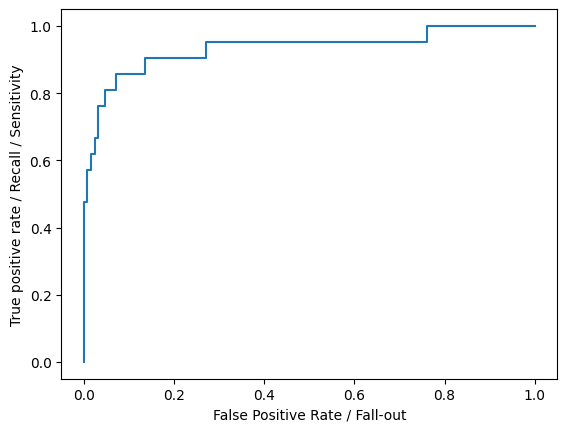

In [35]:
plt.plot(fpr, tpr)
plt.xlabel ("False Positive Rate / Fall-out")
plt.ylabel ("True positive rate / Recall / Sensitivity")

# Second pipeline with XGBoost as the estimator

In [207]:

pipe = Pipeline(steps=[
    ('features_all',AllFeatureCustomTransformer(axis = 1)), 
    ('feature_selection_corr', RemoveCorrelatedFeatures(threshold=0.9)), 
    ('feature_selection', SelectFromModel(LinearSVC(dual="auto", penalty="l1", C = 0.01))), 
    ('standardscaler', StandardScaler()), 
    ("xgb", XGBClassifier()) ]
    )

In [235]:
X_train.shape
len(y_train)
len(pids_train)
np.logspace(-3, 3, 3)
type(X_train)

pandas.core.frame.DataFrame

In [52]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "feature_selection_corr__threshold": (0.7, 0.8, 0.9), 
    "feature_selection__estimator__C": np.logspace(-3, 3, 3), 
    'xgb__learning_rate': [0.1, 0.3, 0.5],
    'xgb__max_depth': [3, 5, 7],
    'xgb__n_estimators': [50, 100, 200]}

# Generate all possible combinations
all_combinations = list(product(*param_grid.values()))
print(len(all_combinations))
# Display the combinations
for combo in all_combinations:
    params_dict = dict(zip(param_grid.keys(), combo))
    print(params_dict)

243
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 50}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 50}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
{'feature_selection_corr__threshold': 0.7, 'feature_selection__estimator__C': 0.001, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 200}
{'feature_selection_corr__threshold': 0.7, '

In [41]:
import os
os.getcwd()

'/Users/jessie/github/algo_ecg/notebooks'

In [48]:
with open('../algo_ecg/search_xgboost.pkl', 'rb') as file:
    search = pickle.load(file)
    auc = pickle.load(file)


In [49]:
print("Best Hyperparameters:", search.best_params_)
print(pd.DataFrame(search.cv_results_))

Best Hyperparameters: {'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.5, 'feature_selection_corr__threshold': 0.9, 'feature_selection__estimator__C': 1000.0}
   iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  \
0     0           72      12.637061      0.331276        14.985637   
1     0           72      14.638292      0.227505        19.259030   
2     0           72      15.291939      0.183557        18.073811   
3     0           72      16.002788      0.276322        16.997257   
4     0           72      13.826748      0.946244        13.929935   
5     1          216      49.497013      4.439757        55.344733   
6     1          216      52.558761      1.991494        43.611412   

   std_score_time param_xgb__n_estimators param_xgb__max_depth  \
0        0.960240                      50                    7   
1        0.220378                      50                    7   
2        0.387686                     200                  

In [53]:
y_test_pred = search.predict(X_test) 
y_test_pred_prob = search.predict_proba(X_test)

print(classification_report(y_test, y_test_pred))
fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob[:, 1])
auc(x=fpr, y=tpr)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       125
           1       0.85      0.81      0.83        21

    accuracy                           0.95       146
   macro avg       0.91      0.89      0.90       146
weighted avg       0.95      0.95      0.95       146



0.9093333333333334

In [ ]:
plt.plot(fpr, tpr)
plt.xlabel ("False Positive Rate / Fall-out")
plt.ylabel ("True positive rate / Recall / Sensitivity")

In [54]:
C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)

In [55]:
C_range

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
       1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

In [ ]:

filename = "search_{}_{}.pkl".format(run_lr, )